# Default Risk Forecast Model — Home Credit

Trong dự án này này, tôi sẽ cùng dựng một model dự đoán **khả năng vỡ nợ** (default) cho bộ dữ liệu Home Credit  - một dịch vụ chuyên cung cấp các hạn mức tín dụng (khoản vay) cho dân số không có tài khoản ngân hàng. Mục tiêu của dự án là xây dựng một mô hình cân đối giữa chỉ số kỹ thuật và mục tiêu kinh doanh thực tế, kết quả của mô hình phải ra một **quyết định duyệt/không duyệt** rõ ràng

Dữ liệu để xác lập mục tiêu kinh doanh được tham khảo từ dữ liệu của các tổ chức tín dụng trên thị trường và HomeCredit với mục tiêu cân đối giữa tỷ lệ chấp nhận khoản vay và trần tỷ lệ nợ xấu chấp nhận: 
- Tỷ lệ chấp nhận khoản vay nằm trong khoảng **60%-70%** 
- Trần tỷ lệ chấp nhận nợ xấu là **4.5%**.

Điểm quan trọng nhất của mô hình nằm ở cách chốt ngưỡng quyết định. Thay vì chạy theo một chỉ số đẹp, tôi sẽ chọn một **ngưỡng quyết định** sao cho đáp ứng mục tiêu kinh doanh. Khi đã chốt, ngưỡng này sẽ được khoá lại và dùng nhất quán để đánh giá và tạo submission. 

Dự án sẽ đi theo trình tự sau

1) **Nhìn nhanh dữ liệu và kiểm tra quan hệ khóa** 
2) **Aggregate các bảng lịch sử** về `SK_ID_CURR` (mỗi khách hàng 1 dòng)  
3) **Ghép feature → split data → preprocessing**  
4) Thiết lập **Baseline Model** trước, sau đó **so sánh vài mô hình** dưới cùng policy  
5) **Chốt threshold** và **tạo submission**



## 1) Import thư viện

Trước khi đụng vào dữ liệu, chúng ta chuẩn bị các thư viện cơ bản cho việc xử lý bảng, dựng pipeline và đánh giá mô hình. Ở đây tôi dùng những công cụ quen thuộc của `pandas` và `scikit-learn`.  


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score, classification_report

pd.set_option("display.max_columns", 200)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")


## 2) Load dữ liệu thô

Bây giờ hãy đọc các bảng dữ liệu Home Credit bao gồm 7 nguồn dữ liệu khác nhau:

* application_train/application_test: dữ liệu huấn luyện và kiểm tra chính với thông tin về mỗi đơn xin vay tại Home Credit. Mỗi khoản vay có hàng riêng và được xác định bởi đặc trưng `SK_ID_CURR`. Dữ liệu đơn xin vay huấn luyện đi kèm với `TARGET` cho biết 0: khoản vay đã được trả hoặc 1: khoản vay không được trả. 
* bureau: dữ liệu về các khoản tín dụng trước đây của khách hàng từ các tổ chức tài chính khác. Mỗi khoản tín dụng trước đây có hàng riêng trong bureau, nhưng một khoản vay trong dữ liệu đơn xin có thể có nhiều khoản tín dụng trước đây.
* bureau_balance: dữ liệu hàng tháng về các khoản tín dụng trước đây trong bureau. Mỗi hàng là một tháng của một khoản tín dụng trước đây, và một khoản tín dụng trước đây có thể có nhiều hàng, một hàng cho mỗi tháng của độ dài tín dụng. 
* previous_application: các đơn xin vay trước đây tại Home Credit của các khách hàng có khoản vay trong dữ liệu đơn xin. Mỗi khoản vay hiện tại trong dữ liệu đơn xin có thể có nhiều khoản vay trước đây. Mỗi đơn xin trước đây có một hàng và được xác định bởi đặc trưng `SK_ID_PREV`. 
* POS_CASH_BALANCE: dữ liệu hàng tháng về các khoản vay điểm bán hàng hoặc tiền mặt trước đây mà khách hàng đã có với Home Credit. Mỗi hàng là một tháng của một khoản vay điểm bán hàng hoặc tiền mặt trước đây, và một khoản vay trước đây có thể có nhiều hàng.
* credit_card_balance: dữ liệu hàng tháng về các thẻ tín dụng trước đây mà khách hàng đã có với Home Credit. Mỗi hàng là một tháng của số dư thẻ tín dụng, và một thẻ tín dụng có thể có nhiều hàng.
* installments_payment: lịch sử thanh toán cho các khoản vay trước đây tại Home Credit. Có một hàng cho mỗi khoản thanh toán đã thực hiện và một hàng cho mỗi khoản thanh toán bị bỏ lỡ. 


In [ ]:
# Load dữ liệu

train = pd.read_csv("/Users/thekiet/Downloads/HomeCredit_Project/application_train.csv")
test  = pd.read_csv("/Users/thekiet/Downloads/HomeCredit_Project/application_test.csv")

bureau = pd.read_csv("/Users/thekiet/Downloads/HomeCredit_Project/bureau.csv")
bureau_balance = pd.read_csv("/Users/thekiet/Downloads/HomeCredit_Project/bureau_balance.csv")
pos = pd.read_csv("/Users/thekiet/Downloads/HomeCredit_Project/POS_CASH_balance.csv")
prev = pd.read_csv("/Users/thekiet/Downloads/HomeCredit_Project/previous_application.csv")
inst = pd.read_csv("/Users/thekiet/Downloads/HomeCredit_Project/installments_payments.csv")
cc = pd.read_csv("/Users/thekiet/Downloads/HomeCredit_Project/credit_card_balance.csv")   

print("train:", train.shape, "test:", test.shape)
print("bureau:", bureau.shape, "bureau_balance:", bureau_balance.shape)
print("pos:", pos.shape, "prev:", prev.shape)
print("inst:", inst.shape)
print("cc:", cc.shape)


train: (307511, 122) test: (48744, 121)
bureau: (1716428, 17) bureau_balance: (27299925, 3)
pos: (10001358, 8) prev: (1670214, 37)
inst: (13605401, 8)
cc: (3840312, 23)


### Nhận xét nhanh

- Bảng chính `application_train` có **307,511 dòng và 122 cột**, còn `application_test` có **48,744 dòng và 121 cột**. Đây là phần cốt lõi của hồ sơ vay nên mỗi hồ sơ tương ứng một dòng.

- Các bảng lịch sử thì lớn hơn nhiều: `bureau` có **1,716,428 dòng** và `bureau_balance` lên tới **27,299,925 dòng**. Tương tự, POS, installments, credit card balance cũng rất lớn vì đây là dữ liệu theo thời gian

=> Không thể ghép thẳng các bảng lịch sử vào bảng chính. Ta sẽ phải **gộp lịch sử** thành các đặc trưng gọn trước, rồi mới ghép về `SK_ID_CURR`. Làm đúng bước này sẽ giúp pipeline sạch và tránh lỗi logic, một lựa chọn rất an toàn.


## 3) Xác lập mục tiêu kinh doanh & Kiểm tra tính hợp lý dữ liệu


In [ ]:
# Business targets + sanity checks

# ===== Business constraints =====     
NPL_CAP_APPROVED = 0.045     # NPL cap cho nhóm approve (tham chiếu)
APPROVAL_TARGET_LOW = 0.6    # Mục tiêu tỷ lệ duyệt vay (60%-70%)
APPROVAL_TARGET_HIGH = 0.7

ID_COL = "SK_ID_CURR"
TARGET_COL = "TARGET"

print("=== BUSINESS TARGETS ===")
print(f"NPL cap (approved):       {NPL_CAP_APPROVED:.2%}")
print(f"Approval target:          {APPROVAL_TARGET_LOW:.0%}–{APPROVAL_TARGET_HIGH:.0%}")

# ===== Main table checks =====
print("\n=== MAIN TABLE CHECKS: train ===")
print("train shape:", train.shape)

# Target distribution
y = train[TARGET_COL]
print("\nTARGET distribution:")
print(y.value_counts(dropna=False))
base_npl = y.mean()
print(f"Base default rate (TARGET=1): {base_npl:.4%}")

# Unique key check
n_unique = train[ID_COL].nunique()
print(f"\nUnique {ID_COL}: {n_unique} / {len(train)}")
print("Duplicate keys in train:", len(train) - n_unique)

# Missing rate overview (top 20)
feature_cols = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
miss_rate = train[feature_cols].isna().mean().sort_values(ascending=False)

print("\nTop 20 missing-rate features (%):")
print((miss_rate.head(20) * 100).round(2).to_string())

# Quick type overview
cat_cols = train[feature_cols].select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in feature_cols if c not in cat_cols]
print("\nFeature types:")
print(f"Total features: {len(feature_cols)} | Numeric: {len(num_cols)} | Categorical: {len(cat_cols)}")

print("\n=== MAIN TABLE CHECKS: test ===")
print("test shape:", test.shape)
print(f"Unique {ID_COL} in test: {test[ID_COL].nunique()} / {len(test)}")
print("Duplicate keys in test:", len(test) - test[ID_COL].nunique())

# ===== Relationship sanity checks =====
def rel_check(df, key, name, head=5):
    dup = df.duplicated(key).sum()
    nunq = df[key].nunique()
    print(f"{name}: shape={df.shape} | unique {key}={nunq} | duplicated rows by {key}={dup}")
    if dup == 0:
        print(f"-> Looks like 1-1 on {key}.")
    else:
        # show some most frequent keys
        top = df[key].value_counts().head(head)
        print("-> Top repeated keys:")
        print(top.to_string())

print("\n=== RELATIONSHIP CHECKS ===")
rel_check(bureau, "SK_ID_CURR", "bureau by SK_ID_CURR") # Một khách hàng có thể có nhiều khoản vay tại các TCTD khác 
rel_check(bureau, "SK_ID_BUREAU", "bureau by SK_ID_BUREAU") #Mỗi dòng bureau phải đại diện cho 1 khoản vay CIC 

rel_check(bureau_balance, "SK_ID_BUREAU", "bureau_balance by SK_ID_BUREAU") #Một khoản vay CIC có thể có lịch sử theo nhiều tháng 

rel_check(prev, "SK_ID_CURR", "previous_application by SK_ID_CURR") #Một khách hàng có thể từng apply nhiều khoản vay tại Home Credit 
rel_check(prev, "SK_ID_PREV", "previous_application by SK_ID_PREV") #Mỗi application có phải 1 record duy nhất 

rel_check(pos, "SK_ID_PREV", "POS_CASH_balance by SK_ID_PREV") #Một khoản vay có gồm nhiều tháng thanh toán ở pos hoặc bằng tiền mặt
rel_check(inst, "SK_ID_PREV", "installments_payments by SK_ID_PREV") #Một khoản vay gồm nhiều tháng thanh toán ở HomeCredit
rel_check(cc, "SK_ID_PREV", "credit_card_balance by SK_ID_PREV") # Một khoản vay trên thẻ có nhiều tháng thanh toán


=== BUSINESS TARGETS ===
NPL cap (approved):       4.50%
Approval target:          60%–70%

=== MAIN TABLE CHECKS: train ===
train shape: (307511, 122)

TARGET distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64
Base default rate (TARGET=1): 8.0729%

Unique SK_ID_CURR: 307511 / 307511
Duplicate keys in train: 0

Top 20 missing-rate features (%):
COMMONAREA_MODE            69.8700
COMMONAREA_MEDI            69.8700
COMMONAREA_AVG             69.8700
NONLIVINGAPARTMENTS_MEDI   69.4300
NONLIVINGAPARTMENTS_AVG    69.4300
NONLIVINGAPARTMENTS_MODE   69.4300
FONDKAPREMONT_MODE         68.3900
LIVINGAPARTMENTS_AVG       68.3500
LIVINGAPARTMENTS_MODE      68.3500
LIVINGAPARTMENTS_MEDI      68.3500
FLOORSMIN_AVG              67.8500
FLOORSMIN_MEDI             67.8500
FLOORSMIN_MODE             67.8500
YEARS_BUILD_MODE           66.5000
YEARS_BUILD_AVG            66.5000
YEARS_BUILD_MEDI           66.5000
OWN_CAR_AGE                65.9900
LANDAREA_MEDI              59.3800
LAN

### Nhận xét nhanh

Ở đây chúng ta thấy base default rate khoảng **8.0729%**. Con số này nói lên rằng dữ liệu bị lệch, tức là số ca không vỡ nợ nhiều hơn nhiều so với số ca vỡ nợ.

Nhiều biến có tỷ lệ thiếu cao (trên 60%), chủ yếu liên quan đến nhà ở, phản ánh thực tế nghiệp vụ hơn là lỗi dữ liệu
=> Missing value cần được xử lý như một tín hiệu thông tin, không drop bừa bãi

Các bảng phụ đều thể hiện đúng quan hệ 1–N 
- bureau theo SK_ID_CURR có rất nhiều duplicated → đúng kỳ vọng vì 1 khách có thể có nhiều khoản vay ở tổ chức khác.
- bureau theo SK_ID_BUREAU là 1–1 → hợp lý vì mỗi SK_ID_BUREAU đại diện cho một khoản tín dụng cụ thể.
- bureau_balance theo SK_ID_BUREAU là 1–N rất lớn → đúng nghiệp vụ vì một khoản tín dụng có nhiều dòng theo tháng (lịch sử trạng thái).
- previous_application theo SK_ID_CURR là 1–N → khách có thể apply nhiều lần.
- previous_application theo SK_ID_PREV là 1–1 → mỗi đơn vay là một record.
- POS / installments / credit_card theo SK_ID_PREV đều là 1–N → đúng vì mỗi khoản vay/thẻ có nhiều kỳ trả góp theo tháng.

## 4) Feature Engineering: `bureau_balance` → `SK_ID_BUREAU`

Giờ tôi sẽ bắt đầu gộp dữ liệu lịch sử. `bureau_balance` là bảng theo **tháng** của từng khoản vay ở Credit Bureau. Mỗi `SK_ID_BUREAU` có nhiều dòng tương ứng nhiều tháng, và cột `STATUS` cho biết tình trạng trả nợ theo từng tháng.

Mục tiêu là biến lịch sử theo tháng thành vài con số tóm tắt dễ dùng cho mô hình. Ví dụ, chúng ta muốn biết một khoản vay có lịch sử dài bao nhiêu tháng, tháng xấu nhất là mức nào, và tần suất các trạng thái ra sao. Khi đã tóm tắt xong, chúng ta sẽ có một bảng gọn theo `SK_ID_BUREAU`, sẵn sàng để ghép với bảng `bureau` ở bước kế tiếp.


In [ ]:
# Feature Engineering: bureau + bureau_balance  -> aggregate về SK_ID_CURR
# -------------------------
# 4.1) bureau_balance -> aggregate về SK_ID_BUREAU
# -------------------------
bb = bureau_balance[["SK_ID_BUREAU", "MONTHS_BALANCE", "STATUS"]].copy()

# map STATUS sang mức "xấu nhất" (0-5), C/X coi như 0 (không delinquent)
status_map = {"0":0, "1":1, "2":2, "3":3, "4":4, "5":5, "C":0, "X":0}
bb["STATUS_NUM"] = bb["STATUS"].map(status_map).fillna(0).astype(np.int8)

# basic agg
bb_basic = bb.groupby("SK_ID_BUREAU").agg(
    BB_MONTHS_CNT=("MONTHS_BALANCE", "size"),
    BB_MONTHS_MIN=("MONTHS_BALANCE", "min"),
    BB_MONTHS_MAX=("MONTHS_BALANCE", "max"),
    BB_STATUS_MAX=("STATUS_NUM", "max"),
).reset_index()

# status count table
bb_counts = (
    bb.groupby(["SK_ID_BUREAU", "STATUS"])
      .size()
      .unstack(fill_value=0)
)

# chuẩn hoá tên cột
bb_counts.columns = [f"BB_STATUS_CNT_{c}" for c in bb_counts.columns]
bb_counts = bb_counts.reset_index()

# merge counts vào basic
bb_agg = bb_basic.merge(bb_counts, on="SK_ID_BUREAU", how="left")

# thêm tỷ trọng theo số tháng (proportion)
status_cnt_cols = [c for c in bb_agg.columns if c.startswith("BB_STATUS_CNT_")]
for c in status_cnt_cols:
    bb_agg[c.replace("_CNT_", "_RATIO_")] = bb_agg[c] / bb_agg["BB_MONTHS_CNT"].replace(0, np.nan)

print("bb_agg shape:", bb_agg.shape)
print(bb_agg.head(10))


bb_agg shape: (817395, 21)
   SK_ID_BUREAU  BB_MONTHS_CNT  BB_MONTHS_MIN  BB_MONTHS_MAX  BB_STATUS_MAX  \
0       5001709             97            -96              0              0   
1       5001710             83            -82              0              0   
2       5001711              4             -3              0              0   
3       5001712             19            -18              0              0   
4       5001713             22            -21              0              0   
5       5001714             15            -14              0              0   
6       5001715             60            -59              0              0   
7       5001716             86            -85              0              0   
8       5001717             22            -21              0              0   
9       5001718             39            -38              0              1   

   BB_STATUS_CNT_0  BB_STATUS_CNT_1  BB_STATUS_CNT_2  BB_STATUS_CNT_3  \
0                0            

### Nhận xét nhanh

Sau khi gộp, chúng ta có `bb_agg` với các đặc trưng dạng “đếm số tháng có khoản vay”, “mốc tháng gần nhất/xa nhất”, và các biến thể hiện trạng thái khoản vay bao gồm:
- `BB_STATUS_CNT_0`: Số tháng trả đúng hạn
- `BB_STATUS_CNT_1`: Số tháng trả trễ 1-29 ngày
- `BB_STATUS_CNT_2`: Số tháng trả trễ 30-59 ngày
- `BB_STATUS_CNT_3`: Số tháng trả trễ 60-89 ngày
- `BB_STATUS_CNT_4`: Số tháng trả trễ 90-119 ngày
- `BB_STATUS_CNT_5`: Số tháng trả trễ bằng hoặc hơn 120 ngày
- `BB_STATUS_CNT_C`: Số tháng đã đóng tài khoản -> coi như tốt
- `BB_STATUS_CNT_X`: Số tháng không có thông tin -> coi như tốt
- `BB_STATUS_RATIO_`: Tỷ lệ số tháng theo mỗi trạng thái so với tổng số tháng có khoản vay

Điều đáng lưu ý là phần lớn tín hiệu theo thời gian đã được nén lại thành các con số ổn định tương tự như phương pháp one-hot. Đây là cách làm thực dụng: mô hình thường học tốt hơn từ những tín hiệu đã tóm tắt, thay vì phải tự đọc cả chuỗi tháng dài. Từ đây chúng ta có thể đi tiếp sang `bureau`, vì `bureau` chính là cầu nối để đưa các thông tin theo `SK_ID_BUREAU` về đúng khách hàng `SK_ID_CURR`.


## 5) Feature Engineering: `bureau` + `bb_agg` → `SK_ID_CURR`

`bureau` là danh sách các khoản tín dụng trước đây của khách hàng ở các tổ chức khác. Điểm quan trọng nằm ở chỗ: một khách hàng (`SK_ID_CURR`) có thể có rất nhiều khoản trong `bureau`, và mỗi khoản đó lại có lịch sử theo tháng trong `bureau_balance`.

Dưới đây tôi sẽ làm hai bước nối tiếp nhau. Đầu tiên, ghép `bureau` với `bb_agg` theo `SK_ID_BUREAU` để mỗi khoản tín dụng có thêm các đặc trưng “lịch sử theo tháng đã được tóm tắt” ở bước trước đó. Sau đó, chúng ta gộp tiếp về `SK_ID_CURR` để ra đúng dạng “mỗi khách hàng một dòng”. Đây là bước quan trọng quyết định cấu trúc toàn bộ pipeline phía sau.


In [18]:
# -------------------------
# 4.2) bureau + bb_agg -> enrich theo SK_ID_BUREAU
# -------------------------
b = bureau.copy()

# merge bureau_balance features vào bureau
b = b.merge(bb_agg, on="SK_ID_BUREAU", how="left")

# one-hot encoding biến CREDIT_ACTIVE (ít category, rất hữu dụng)
active_dum = pd.get_dummies(b["CREDIT_ACTIVE"], prefix="B_ACTIVE", dummy_na=True).astype(np.int8)
b = pd.concat([b, active_dum], axis=1)

# chọn các numeric cốt lõi để aggregate (ổn định + hay dùng)
num_cols_bureau = [
    "DAYS_CREDIT", "DAYS_CREDIT_ENDDATE", "DAYS_ENDDATE_FACT",
    "DAYS_CREDIT_UPDATE",
    "AMT_CREDIT_SUM", "AMT_CREDIT_SUM_DEBT", "AMT_CREDIT_SUM_OVERDUE",
    "AMT_CREDIT_MAX_OVERDUE",
    "CNT_CREDIT_PROLONG",
    "AMT_ANNUITY"
]
num_cols_bureau = [c for c in num_cols_bureau if c in b.columns]

# -------------------------
# 4.3) aggregate bureau -> SK_ID_CURR
# -------------------------
agg_dict = {}

# counts
agg_dict["SK_ID_BUREAU"] = ["count"]  # số khoản vay bureau

# numeric aggregations
for c in num_cols_bureau:
    agg_dict[c] = ["mean", "sum", "max", "min"]

# bureau_balance-derived fields (đã ở b sau merge) -> aggregate nhẹ
bb_feats_in_b = [c for c in b.columns if c.startswith(("BB_MONTHS_", "BB_STATUS_MAX", "BB_STATUS_CNT_", "BB_STATUS_RATIO_"))]
for c in bb_feats_in_b:
    # với count/ratio: mean là đủ để biểu diễn
    agg_dict[c] = ["mean", "max"]

# CREDIT_ACTIVE dummies
active_cols = active_dum.columns.tolist()
for c in active_cols:
    agg_dict[c] = ["sum", "mean"]

bureau_agg = (
    b.groupby(ID_COL)
     .agg(agg_dict)
)

# flatten multiindex columns
bureau_agg.columns = [f"BUREAU_{a}_{b}" for a, b in bureau_agg.columns]
bureau_agg = bureau_agg.reset_index()

# derived ratios (tính sau aggregate để ổn định)
# debt / credit_sum
sum_credit = bureau_agg.get("BUREAU_AMT_CREDIT_SUM_sum")
sum_debt   = bureau_agg.get("BUREAU_AMT_CREDIT_SUM_DEBT_sum")
sum_over   = bureau_agg.get("BUREAU_AMT_CREDIT_SUM_OVERDUE_sum")

if sum_credit is not None and sum_debt is not None:
    bureau_agg["BUREAU_DEBT_TO_CREDIT_SUM"] = sum_debt / sum_credit.replace(0, np.nan)

if sum_credit is not None and sum_over is not None:
    bureau_agg["BUREAU_OVERDUE_TO_CREDIT_SUM"] = sum_over / sum_credit.replace(0, np.nan)

print("\n=== bureau_agg ===")
print("bureau_agg shape:", bureau_agg.shape)
print(bureau_agg.head(10))

# -------------------------
# 4.4) merge vào train/test (tạo bản có thêm feature)
# -------------------------
train_1 = train.merge(bureau_agg, on=ID_COL, how="left")
test_1  = test.merge(bureau_agg, on=ID_COL, how="left")

new_cols = [c for c in train_1.columns if c.startswith("BUREAU_")]

print("\n=== MERGE RESULT ===")
print("train_1:", train_1.shape, "| added bureau features:", len(new_cols))
print("test_1 :", test_1.shape,  "| added bureau features:", len([c for c in test_1.columns if c.startswith('BUREAU_')]))

# missing-rate của feature mới
miss_new = train_1[new_cols].isna().mean().sort_values(ascending=False)

print("\nTop 20 missing-rate of NEW bureau features (%):")
print((miss_new.head(20) * 100).round(2).to_string())

print("\nBase NPL (train):", f"{train_1[TARGET_COL].mean():.4%}")



=== bureau_agg ===
bureau_agg shape: (305811, 94)
   SK_ID_CURR  BUREAU_SK_ID_BUREAU_count  BUREAU_DAYS_CREDIT_mean  \
0      100001                          7                -735.0000   
1      100002                          8                -874.0000   
2      100003                          4              -1,400.7500   
3      100004                          2                -867.0000   
4      100005                          3                -190.6667   
5      100007                          1              -1,149.0000   
6      100008                          3                -757.3333   
7      100009                         18              -1,271.5000   
8      100010                          2              -1,939.5000   
9      100011                          4              -1,773.0000   

   BUREAU_DAYS_CREDIT_sum  BUREAU_DAYS_CREDIT_max  BUREAU_DAYS_CREDIT_min  \
0                   -5145                     -49                   -1572   
1                   -6992          

### Nhận xét nhanh

Chỉ one-hot encoding biến `CREDIT_ACTIVE`, không làm với `CREDIT_TYPE` vì số lượng category rất nhiều, làm tăng chiều dữ liệu, phức tạp hoá mô hình, không phải biến quan trọng với bài toán.

Kết quả là `bureau_agg` có kích thước **(305,811, 94)**. Con số dòng nhỏ hơn bảng train vì không phải khách hàng nào cũng có dữ liệu ở Credit Bureau hoặc không phải khách nào cũng được ghi nhận đầy đủ.

Lưu ý missing sau khi merge không phải lúc nào cũng xấu. Với bài toán này, missing thường có nghĩa là khách hàng không có loại lịch sử đó, và đó cũng là một tín hiệu. Quan trọng là tôi sẽ xử lý missing nhất quán trong phần preprocess của pipeline, để mô hình học đúng ý nghĩa các biến có tỷ lệ missing cao


## 6) Feature Engineering: `previous_application` + POS / Installments / Credit Card → `SK_ID_CURR`

Tiếp theo là nhóm dữ liệu lịch sử **nội bộ Home Credit**. `previous_application` cho ta biết khách từng nộp hồ sơ trước đây như thế nào, có được duyệt hay không, điều kiện ra sao. Các bảng như POS, installments, credit card balance lại cho thấy cách khách trả nợ theo thời gian: có trễ hạn không, trả đủ không, mức sử dụng hạn mức ra sao.

Phần tiếp theo làm tương tự như phần bureau: mỗi bảng lịch sử được gộp về vài đặc trưng tóm tắt, sau đó tất cả được ghép về `SK_ID_CURR`. Tôi sẽ xử lý các biến tín hiệu gọn gàng, chi tiết ở bên dưới

In [ ]:
# Feature Engineering: prev + POS/INST/CC -> aggregate về SK_ID_CURR, merge vào train_1/test_1
# -------------------------
# 5.1) previous_application -> SK_ID_CURR
# -------------------------
prev_small_cols = [
    "SK_ID_CURR", "SK_ID_PREV",
    "AMT_ANNUITY", "AMT_APPLICATION", "AMT_CREDIT", "AMT_DOWN_PAYMENT",
    "RATE_DOWN_PAYMENT",
    "DAYS_DECISION",
    "CNT_PAYMENT",
    "NAME_CONTRACT_STATUS",
    "NAME_CONTRACT_TYPE"
]
prev_use = prev[[c for c in prev_small_cols if c in prev.columns]].copy()

# one-hot 2 cột categorical phổ biến (giới hạn để tránh nặng)
for col in ["NAME_CONTRACT_STATUS", "NAME_CONTRACT_TYPE"]:
    if col in prev_use.columns:
        d = pd.get_dummies(prev_use[col], prefix=f"PREV_{col}", dummy_na=True).astype(np.int8)
        prev_use = pd.concat([prev_use.drop(columns=[col]), d], axis=1)

# aggregate prev về SK_ID_CURR
prev_num_cols = [c for c in prev_use.columns if c not in ["SK_ID_CURR", "SK_ID_PREV"] and prev_use[c].dtype != "uint8" and prev_use[c].dtype != "int8"]
# (ở đây dummy đã int8, numeric float/int sẽ vào prev_num_cols)
# nhưng để chắc: numeric columns theo dtype number trừ dummy vẫn ok
prev_num_cols = [c for c in prev_use.columns if c not in ["SK_ID_CURR", "SK_ID_PREV"] and pd.api.types.is_numeric_dtype(prev_use[c])]

agg_prev = {}
agg_prev["SK_ID_PREV"] = ["count"]  # số lần apply trước đó

# với numeric continuous: mean/sum/max/min
cont_candidates = ["AMT_ANNUITY","AMT_APPLICATION","AMT_CREDIT","AMT_DOWN_PAYMENT","RATE_DOWN_PAYMENT","DAYS_DECISION","CNT_PAYMENT"]
for c in cont_candidates:
    if c in prev_use.columns:
        agg_prev[c] = ["mean", "sum", "max", "min"]

# với dummy: sum/mean (đếm và tỷ lệ)
dummy_cols = [c for c in prev_use.columns if c.startswith("PREV_")]
for c in dummy_cols:
    agg_prev[c] = ["sum", "mean"]

prev_agg = prev_use.groupby("SK_ID_CURR").agg(agg_prev)
prev_agg.columns = [f"PREV_{a}_{b}" for a, b in prev_agg.columns]
prev_agg = prev_agg.reset_index()

print("prev_agg shape:", prev_agg.shape)

# mapping SK_ID_PREV -> SK_ID_CURR để roll-up các bảng theo SK_ID_PREV
prev_key = prev[["SK_ID_PREV", "SK_ID_CURR"]].drop_duplicates()

# -------------------------
# 5.2) POS_CASH_balance -> SK_ID_PREV -> SK_ID_CURR
# -------------------------
pos_use_cols = [c for c in ["SK_ID_PREV", "MONTHS_BALANCE", "CNT_INSTALMENT", "CNT_INSTALMENT_FUTURE", "SK_DPD", "SK_DPD_DEF"] if c in pos.columns]
pos_use = pos[pos_use_cols].copy()

pos_prev_agg = pos_use.groupby("SK_ID_PREV").agg(
    POS_MONTHS_CNT=("MONTHS_BALANCE", "size"),
    POS_MONTHS_MIN=("MONTHS_BALANCE", "min"),
    POS_MONTHS_MAX=("MONTHS_BALANCE", "max"),
    POS_SK_DPD_MEAN=("SK_DPD", "mean"),
    POS_SK_DPD_MAX=("SK_DPD", "max"),
    POS_SK_DPD_DEF_MEAN=("SK_DPD_DEF", "mean"),
    POS_SK_DPD_DEF_MAX=("SK_DPD_DEF", "max"),
    POS_CNT_INST_MEAN=("CNT_INSTALMENT", "mean"),
    POS_CNT_INST_FUTURE_MEAN=("CNT_INSTALMENT_FUTURE", "mean"),
).reset_index()

pos_curr = pos_prev_agg.merge(prev_key, on="SK_ID_PREV", how="left")
pos_curr = pos_curr.dropna(subset=["SK_ID_CURR"])

pos_curr_agg = pos_curr.groupby("SK_ID_CURR").agg(
    POS_PREV_CNT=("SK_ID_PREV", "nunique"),
    POS_MONTHS_CNT_SUM=("POS_MONTHS_CNT", "sum"),
    POS_SK_DPD_MAX_MAX=("POS_SK_DPD_MAX", "max"),
    POS_SK_DPD_MEAN_MEAN=("POS_SK_DPD_MEAN", "mean"),
    POS_SK_DPD_DEF_MAX_MAX=("POS_SK_DPD_DEF_MAX", "max"),
    POS_SK_DPD_DEF_MEAN_MEAN=("POS_SK_DPD_DEF_MEAN", "mean"),
).reset_index()

print("pos_curr_agg shape:", pos_curr_agg.shape)

# -------------------------
# 5.3) installments_payments -> SK_ID_PREV -> SK_ID_CURR
# -------------------------
inst_use_cols = [c for c in ["SK_ID_PREV", "AMT_INSTALMENT", "AMT_PAYMENT", "DAYS_INSTALMENT", "DAYS_ENTRY_PAYMENT"] if c in inst.columns]
inst_use = inst[inst_use_cols].copy()

# derived features
inst_use["INST_PAY_RATIO"] = inst_use["AMT_PAYMENT"] / inst_use["AMT_INSTALMENT"].replace(0, np.nan)
inst_use["INST_LATE_DAYS"] = inst_use["DAYS_ENTRY_PAYMENT"] - inst_use["DAYS_INSTALMENT"]  # >0 late, <0 early

inst_prev_agg = inst_use.groupby("SK_ID_PREV").agg(
    INST_CNT=("AMT_PAYMENT", "size"),
    INST_PAY_RATIO_MEAN=("INST_PAY_RATIO", "mean"),
    INST_PAY_RATIO_MIN=("INST_PAY_RATIO", "min"),
    INST_PAY_RATIO_MAX=("INST_PAY_RATIO", "max"),
    INST_LATE_DAYS_MEAN=("INST_LATE_DAYS", "mean"),
    INST_LATE_DAYS_MAX=("INST_LATE_DAYS", "max"),
).reset_index()

inst_curr = inst_prev_agg.merge(prev_key, on="SK_ID_PREV", how="left")
inst_curr = inst_curr.dropna(subset=["SK_ID_CURR"])

inst_curr_agg = inst_curr.groupby("SK_ID_CURR").agg(
    INST_PREV_CNT=("SK_ID_PREV", "nunique"),
    INST_CNT_SUM=("INST_CNT", "sum"),
    INST_PAY_RATIO_MEAN_MEAN=("INST_PAY_RATIO_MEAN", "mean"),
    INST_PAY_RATIO_MIN_MIN=("INST_PAY_RATIO_MIN", "min"),
    INST_LATE_DAYS_MAX_MAX=("INST_LATE_DAYS_MAX", "max"),
    INST_LATE_DAYS_MEAN_MEAN=("INST_LATE_DAYS_MEAN", "mean"),
).reset_index()

print("inst_curr_agg shape:", inst_curr_agg.shape)

# -------------------------
# 5.4) credit_card_balance -> SK_ID_PREV -> SK_ID_CURR
# -------------------------
cc_use_cols = [c for c in ["SK_ID_PREV", "MONTHS_BALANCE", "AMT_BALANCE", "AMT_CREDIT_LIMIT_ACTUAL", "SK_DPD", "SK_DPD_DEF"] if c in cc.columns]
cc_use = cc[cc_use_cols].copy()

cc_prev_agg = cc_use.groupby("SK_ID_PREV").agg(
    CC_MONTHS_CNT=("MONTHS_BALANCE", "size"),
    CC_BAL_MEAN=("AMT_BALANCE", "mean"),
    CC_BAL_MAX=("AMT_BALANCE", "max"),
    CC_LIMIT_MEAN=("AMT_CREDIT_LIMIT_ACTUAL", "mean"),
    CC_SK_DPD_MEAN=("SK_DPD", "mean"),
    CC_SK_DPD_MAX=("SK_DPD", "max"),
    CC_SK_DPD_DEF_MEAN=("SK_DPD_DEF", "mean"),
    CC_SK_DPD_DEF_MAX=("SK_DPD_DEF", "max"),
).reset_index()

cc_curr = cc_prev_agg.merge(prev_key, on="SK_ID_PREV", how="left")
cc_curr = cc_curr.dropna(subset=["SK_ID_CURR"])

cc_curr_agg = cc_curr.groupby("SK_ID_CURR").agg(
    CC_PREV_CNT=("SK_ID_PREV", "nunique"),
    CC_MONTHS_CNT_SUM=("CC_MONTHS_CNT", "sum"),
    CC_BAL_MAX_MAX=("CC_BAL_MAX", "max"),
    CC_BAL_MEAN_MEAN=("CC_BAL_MEAN", "mean"),
    CC_LIMIT_MEAN_MEAN=("CC_LIMIT_MEAN", "mean"),
    CC_SK_DPD_DEF_MAX_MAX=("CC_SK_DPD_DEF_MAX", "max"),
    CC_SK_DPD_DEF_MEAN_MEAN=("CC_SK_DPD_DEF_MEAN", "mean"),
).reset_index()

print("cc_curr_agg shape:", cc_curr_agg.shape)

# -------------------------
# 5.5) Merge tất cả vào train_1/test_1 -> train_2/test_2
# -------------------------
train_2 = train_1.merge(prev_agg, on=ID_COL, how="left") \
                .merge(pos_curr_agg, on=ID_COL, how="left") \
                .merge(inst_curr_agg, on=ID_COL, how="left") \
                .merge(cc_curr_agg, on=ID_COL, how="left")

test_2  = test_1.merge(prev_agg, on=ID_COL, how="left") \
               .merge(pos_curr_agg, on=ID_COL, how="left") \
               .merge(inst_curr_agg, on=ID_COL, how="left") \
               .merge(cc_curr_agg, on=ID_COL, how="left")

new_cols_5 = [c for c in train_2.columns if c.startswith(("PREV_", "POS_", "INST_", "CC_"))]

print("\n=== MERGE RESULT Cell 5 ===")
print("train_2:", train_2.shape, "| added prev/pos/inst/cc features:", len(new_cols_5))
print("test_2 :", test_2.shape,  "| added prev/pos/inst/cc features:", len([c for c in test_2.columns if c.startswith(('PREV_','POS_','INST_','CC_'))]))

miss_new5 = train_2[new_cols_5].isna().mean().sort_values(ascending=False)
print("\nTop 20 missing-rate of NEW features from Cell 5 (%):")
print((miss_new5.head(20) * 100).round(2).to_string())
print("\nBase NPL (train):", f"{train_1[TARGET_COL].mean():.4%}")

print(train_2.head(5))


prev_agg shape: (338857, 50)
pos_curr_agg shape: (334359, 7)
inst_curr_agg shape: (336935, 7)
cc_curr_agg shape: (92447, 8)

=== MERGE RESULT Cell 5 ===
train_2: (307511, 283) | added prev/pos/inst/cc features: 68
test_2 : (48744, 282) | added prev/pos/inst/cc features: 68

Top 20 missing-rate of NEW features from Cell 5 (%):
CC_SK_DPD_DEF_MEAN_MEAN       74.6600
CC_SK_DPD_DEF_MAX_MAX         74.6600
CC_LIMIT_MEAN_MEAN            74.6600
CC_BAL_MEAN_MEAN              74.6600
CC_BAL_MAX_MAX                74.6600
CC_MONTHS_CNT_SUM             74.6600
CC_PREV_CNT                   74.6600
PREV_AMT_DOWN_PAYMENT_mean    11.0300
PREV_RATE_DOWN_PAYMENT_max    11.0300
PREV_RATE_DOWN_PAYMENT_mean   11.0300
PREV_AMT_DOWN_PAYMENT_min     11.0300
PREV_AMT_DOWN_PAYMENT_max     11.0300
PREV_RATE_DOWN_PAYMENT_min    11.0300
POS_SK_DPD_MAX_MAX             6.6800
POS_SK_DPD_DEF_MEAN_MEAN       6.6800
POS_PREV_CNT                   6.6800
POS_MONTHS_CNT_SUM             6.6800
POS_SK_DPD_MEAN_MEAN      

### Nhận xét nhanh

Chỉ chọn một số biến quan trọng mỗi bảng để tạo thống kê **(trung bình/lớn nhất/nhỏ nhất/tổng)** hoặc **tần suất**. Lưu ý: ở đây tôi sẽ lấy **(trung bình/lớn nhất/nhỏ nhất/tổng)** với các biến numeric **(số tiền/số ngày/số kỳ)**, với các biến one-hot tôi sẽ lấy **(sum/mean)**, ở đây có thể hiểu rằng đơn giản **sum** để đếm số lần khách rơi vào trạng thái đó, trong khi **mean** xem tỷ lệ từ chối/được duyệt của các khoản vay lịch sử 

Với bảng `previous_application`

- `AMT_APPLICATION`: Số tiền khách vay
- `AMT_CREDIT`: Số tiền tín dụng được cấp
- `AMT_ANNUITY`: Khoản trả định kỳ
- `AMT_DOWN_PAYMENT`: Khoản đặt cọc 
- `RATE_DOWN_PAYMENT`: Tỷ lệ đặt cọc
- `CNT_PAYMENT`: Số kỳ trả dự kiến
- `DAYS_DECISION`: Thời điểm ra quyết định của hồ sơ trước đó so với hiện tại -> chủ yếu dùng nó như một tín hiệu về độ gần/xa của lịch sử. 
- `NAME_CONTRACT_STATUS`: Trạng thái hồ sơ 
- `NAME_CONTRACT_TYPE`: Loại hợp đồng

Với bảng `POS_CASH_balance`

- `MONTHS_BALANCE`: Số tháng quan sát từ ngày nộp hồ sơ (số âm)
- `CNT_INSTALMENT`: Số kỳ trả góp (có thể thay đổi theo thời gian)
- `CNT_INSTALMENT_FUTURE`: Số kỳ còn lại chưa trả tại thời điển quan sát
- `NAME_CONTRACT_STATUS`: Trạng thái hợp đồng trong tháng -> bỏ qua biến này vì one-hot tăng chiều dữ liệu quá mạnh, có thể thay thế bằng các biến có ý nghĩa tương tự khác trong pos
- `SK_DPD`: Số ngày trễ hạn trong tháng quan sát
- `SK_DPD_DEF`: Số ngày trễ hạn trong tháng nhưng có dung sai -> một số khoản nợ nhỏ có thể bỏ qua tuỳ quy ước

Với bảng `installments_payments`
- `AMT_INSTALMENT`: Số tiền phải trả kỳ đó
- `AMT_PAYMENT`: Số tiền thực trả
- `DAYS_INSTALMENT`: Ngày đến hạn của kỳ trả tính theo ngày nộp hồ sơ hiện tại (số âm)
- `DAYS_ENTRY_PAYMENT`: Ngày thực trả tương đối theo ngày nộp hồ sơ hiện tại

Với bảng `credit_card_balance`
- `MONTHS_BALANCE`: Tháng quan sát so với ngày nộp hồ sơ hiện tại (số âm)
- `AMT_BALANCE`: Dư nợ cuối kỳ
- `AMT_CREDIT_LIMIT_ACTUAL`: Hạn mức thực tế của thẻ trong thánh
- `SK_DPD`: Số ngày quá hạn trong tháng
- `SK_DPD_DEF`: Số ngày quá hạn ở mức 'default'/nặng trong tháng


Sau khi ghép xong nhóm này, bảng train đã tăng lên **(307,511, 283)**, tức là chúng ta thêm khoảng **68 đặc trưng** là các hành vi lịch sử từ `prev/pos/inst/cc` vào mô hình một cách có chọn lọc, không sử dụng các biến có ý nghĩa giống nhau hoặc khó diễn giải

Bạn sẽ thấy missing rate của một số đặc trưng thẻ tín dụng rất cao (khoảng **74.66%**). Trường hợp phổ biến là nhiều khách hàng không hề có lịch sử thẻ tín dụng trong hệ thống, nên các cột liên quan tới credit card sẽ trống. Đây là missing có ý nghĩa và chúng ta sẽ xử lý nó bằng cách điền giá trị hợp lý trong pipeline, để mô hình có thể học được rằng “không có lịch sử” cũng là một trạng thái.


## 7) Split dữ liệu + Preprocess pipeline

Tới đây đã có một bảng feature khá đầy đủ. Bước này tôi muốn chuẩn hoá cách train và đánh giá để tránh vô tình nhìn trước đáp án. Vì vậy tôi sẽ chia dữ liệu thành train, validation và test theo cùng một tỉ lệ, đồng thời giữ tỷ lệ default tương tự nhau giữa các phần. Đánh giá mô hình có thể không chính xác nếu dữ liệu lệch

Cùng lúc, tôi dựng một preprocess pipeline thống nhất cho cả train và test. Với biến số điền missing và có thể scale để mô hình dễ học. Với biến phân loại, ta điền missing rồi one-hot để biến thành dạng số. Làm bằng pipeline giúp toàn bộ quy trình sạch: fit quy trình trên train, rồi áp dụng pipeline đó cho validation, test


In [ ]:
# Split + Preprocess Pipeline
from sklearn.model_selection import train_test_split

# ===== Prepare X, y =====
df = train_2.copy()
y = df[TARGET_COL].astype(int)
X = df.drop(columns=[TARGET_COL])

# drop ID khỏi feature
if ID_COL in X.columns:
    X = X.drop(columns=[ID_COL])

# detect feature types
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

print("=== DATA FOR MODEL ===")
print("X shape:", X.shape, "| y mean (base NPL):", f"{y.mean():.4%}")
print("Numeric:", len(num_cols), "| Categorical:", len(cat_cols))

# ===== Split: 60/20/20 with stratify =====
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print("\n=== SPLIT ===")
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# ===== Preprocess =====
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)


=== DATA FOR MODEL ===
X shape: (307511, 281) | y mean (base NPL): 8.0729%
Numeric: 265 | Categorical: 16

=== SPLIT ===
Train: (184506, 281) Val: (61502, 281) Test: (61503, 281)


### Nhận xét nhanh 

Sau khi chọn cột và tách nhãn, dữ liệu đưa vào mô hình có kích thước **(307,511, 281)** và base default rate vẫn khoảng **8.0729%**, tức là giữ nguyên phân phối gốc. 

Phần split cũng rõ ràng **(60/20/20 cho train/validate/test)**: train khoảng **184,506 dòng**, validation khoảng **61,502 dòng**, test khoảng **61,503 dòng**. Từ đây trở đi, mọi so sánh mô hình sẽ dùng cùng cách chia này đảm bảo kết quả công bằng. Đồng thời split data trước khi xử lý scale tránh lỗi data leakage xảy ra giữa test và train.

Tôi sử dụng **SimpleImputer** xử lý NA ở các numeric feature, thay thế bằng median - tránh bị bias bởi outlier và xử lý NA ở category feature bằng cách thay bằng giá trị xuất hiện nhiều nhất. Sử dụng **StandardScaler** (with_mean = False) vì dữ liệu sparse (nhiều 0) và có ý nghĩa nên scale phải giữ được tính chất dữ liệu.

Vì đặc trưng dữ liệu của bài toán này có chứa rất nhiều biến và phần lớn là các biến được tổng hợp từ nhiều bảng nên hiện tượng vài biến có ý nghĩa tương đương (đi cùng nhau) là khá tự nhiên nên tôi không cố gắng kiểm tra correlation giữa các biến vì sẽ gây hiện tượng hoang hoang, drop nhầm các biến chủ chốt và correlation cũng bị bias bởi các biến chứa nhiều giá trị 0 hoặc NA. Thay vào đó, việc chọn feature sẽ được xem xét bằng ý nghĩa biến và nghiệp vụ để lọc các biến tương đương gây nhiễu việc học của mô hình.



## 8) Baseline Logistic Regression + Policy table

Bây giờ tôi chạy một baseline trước. Logistic Regression sẽ là lựa chọn hợp lý vì dễ train, dễ hiểu, và thường cho một mức hiệu quả ổn để làm mốc so sánh. Mục tiêu ở đây không phải chứng minh logistic là tốt nhất, mà là tạo một chuẩn để biết pipeline đang chạy đúng và policy đang được áp dụng đúng.

Trong cell code dưới đây, tôi sẽ làm 2 việc:

- Đánh giá vài chỉ số không phụ thuộc ngưỡng như ROC-AUC và AP (PR-AUC) để xem mô hình phân biệt tốt tới đâu. Trong đó ROC_AUC đo khả năng mô hình xếp đúng thứ tự rủi ro: nếu mình bốc ngẫu nhiên một khách default và một khách không default, ROC_AUC cao nghĩa là mô hình thường cho điểm rủi ro của khách default cao hơn khách tốt. Chỉ số này rất hữu ích để kiểm tra mô hình có học được tín hiệu hay không và so sánh chất lượng xếp hạng tổng quan giữa các mô hình. Tuy nhiên vì dữ liệu lệch lớp, ROC_AUC đôi khi vẫn nhìn đẹp dù mô hình chưa thật sự hữu ích cho quyết định reject/approve. Vì vậy tôi nhìn thêm PR_AUC vì nó tập trung trực tiếp vào câu hỏi quan trọng với bài toán policy: ưu tiên xem nhóm rủi ro cao trước thì trong nhóm bị đánh dấu rủi ro đó, tỷ lệ default thật sự là bao nhiêu và mô hình bắt được bao nhiêu default.

- Quan trọng hơn là tạo policy table bằng cách quét nhiều ngưỡng, rồi chọn ngưỡng nào vừa nằm trong khoảng tỷ lệ duyệt mong muốn, vừa giữ tỷ lệ vỡ nợ của nhóm được duyệt dưới mức tối đa. 


In [ ]:
# Baseline Logistic + Policy table

# ===== Baseline model =====
baseline_clf = LogisticRegression(
    max_iter=2000,
    solver="saga",
    n_jobs=-1
)

baseline_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", baseline_clf)
])

# ===== Train =====
baseline_model.fit(X_train, y_train)

# ===== Predict proba =====
proba_val = baseline_model.predict_proba(X_val)[:, 1]
proba_test = baseline_model.predict_proba(X_test)[:, 1]

# ===== Threshold-independent metrics =====
val_auc = roc_auc_score(y_val, proba_val)
val_ap  = average_precision_score(y_val, proba_val)
test_auc = roc_auc_score(y_test, proba_test)
test_ap  = average_precision_score(y_test, proba_test)

print("\n=== THRESHOLD-INDEPENDENT METRICS (Baseline Logistic) ===")
print(f"VAL  ROC-AUC: {val_auc:.4f} | PR-AUC(AP): {val_ap:.4f}")
print(f"TEST ROC-AUC: {test_auc:.4f} | PR-AUC(AP): {test_ap:.4f}")

# ===== Policy table helper =====
def build_policy_table(y_true, proba, thresholds):
    rows = []
    y_true = np.asarray(y_true).astype(int)
    proba = np.asarray(proba)

    total_default = (y_true == 1).sum()

    for t in thresholds:
        approved = proba < t
        rejected = ~approved

        approval_rate = approved.mean()
        reject_rate = 1 - approval_rate

        npl_approved = y_true[approved].mean() if approved.sum() > 0 else np.nan
        npl_rejected = y_true[rejected].mean() if rejected.sum() > 0 else np.nan

        caught_default = ((y_true == 1) & rejected).sum()
        recall_catch_default = caught_default / total_default if total_default > 0 else np.nan

        rows.append([t, approval_rate, reject_rate, npl_approved, npl_rejected, recall_catch_default])

    return pd.DataFrame(rows, columns=[
        "threshold", "approval_rate", "reject_rate",
        "npl_approved", "npl_rejected", "recall_catch_default"
    ])

def choose_threshold_by_policy(y_true, proba, proba_grid=None):
    """
    Chọn threshold theo business policy:
    - approval_rate nằm trong [APPROVAL_TARGET_LOW, APPROVAL_TARGET_HIGH]
    - ưu tiên npl_approved <= NPL_CAP_APPROVED
    - ưu tiên bắt default tốt (recall_catch_default cao), sau đó npl_approved thấp
    Return: t_star, note, chosen_row_df(1 row), policy_table_df
    """
    y_true = np.asarray(y_true).astype(int)
    proba = np.asarray(proba)

    if proba_grid is None:
        qs = np.linspace(0.60, 0.95, 71)
        thresholds = np.unique(np.quantile(proba, qs))
        thresholds = np.clip(thresholds, 1e-6, 1-1e-6)
    else:
        thresholds = np.array(sorted(set(proba_grid)))
        thresholds = np.clip(thresholds, 1e-6, 1-1e-6)

    policy = build_policy_table(y_true, proba, thresholds)

    cand = policy[
        (policy["approval_rate"] >= APPROVAL_TARGET_LOW) &
        (policy["approval_rate"] <= APPROVAL_TARGET_HIGH)
    ].copy()

    if len(cand) > 0:
        feasible = cand[cand["npl_approved"] <= NPL_CAP_APPROVED].copy()

        if len(feasible) > 0:
            chosen = feasible.sort_values(
                ["recall_catch_default", "npl_approved"],
                ascending=[False, True]
            ).head(1)
            note = "FOUND threshold meeting approval band AND NPL cap."
        else:
            chosen = cand.assign(
                npl_gap=(cand["npl_approved"] - NPL_CAP_APPROVED).abs()
            ).sort_values(
                ["npl_gap", "recall_catch_default"],
                ascending=[True, False]
            ).head(1)
            note = "No threshold meets NPL cap within approval band; picked closest to NPL cap."
    else:
        mid = (APPROVAL_TARGET_LOW + APPROVAL_TARGET_HIGH) / 2
        chosen = policy.assign(
            appr_gap=(policy["approval_rate"] - mid).abs()
        ).sort_values(
            ["appr_gap", "npl_approved"],
            ascending=[True, True]
        ).head(1)
        note = "No threshold hits approval band; picked closest approval rate."

    t_star = float(chosen["threshold"].iloc[0])
    return t_star, note, chosen, policy

# ===== Pick threshold on VAL by business policy =====
t_star, choice_note, chosen, policy_val = choose_threshold_by_policy(y_val, proba_val)

print("\n=== POLICY (VALIDATION) — Baseline Logistic ===")
print(choice_note)
print("Chosen threshold t* =", t_star)
print(chosen.to_string(index=False))

print("\nTop 10 rows around mid-approval (diagnostic):")
mid = (APPROVAL_TARGET_LOW + APPROVAL_TARGET_HIGH) / 2
tmp = policy_val.assign(appr_gap=(policy_val["approval_rate"] - mid).abs())
print(tmp.sort_values(["appr_gap", "npl_approved"]).head(10).to_string(index=False))

# ===== Evaluate at chosen threshold on VAL + TEST =====
def report_at_threshold(y_true, proba, t, title):
    y_true = np.asarray(y_true).astype(int)
    proba = np.asarray(proba)

    y_pred = (proba >= t).astype(int)  # 1 = high risk/default -> reject
    print(f"\n--- {title} @ threshold={t:.6f} (predict 1 if proba>=t) ---")
    print(classification_report(y_true, y_pred, digits=4))

    approved = proba < t
    appr = approved.mean()
    npl_app = y_true[approved].mean() if approved.sum() > 0 else np.nan

    total_default = (y_true == 1).sum()
    caught = ((y_true == 1) & (~approved)).sum() / total_default if total_default > 0 else np.nan

    print(f"Approval rate: {appr:.2%}")
    print(f"NPL approved:  {npl_app:.2%}  (cap ref: {NPL_CAP_APPROVED:.2%})")
    print(f"Recall catch default (rejected/total default): {caught:.2%}")

report_at_threshold(y_val, proba_val, t_star, "VALIDATION")
report_at_threshold(y_test, proba_test, t_star, "TEST")

# ===== Keep for next cells =====
best_threshold = t_star
policy_table_val = policy_val


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



=== THRESHOLD-INDEPENDENT METRICS (Baseline Logistic) ===
VAL  ROC-AUC: 0.7619 | PR-AUC(AP): 0.2357
TEST ROC-AUC: 0.7699 | PR-AUC(AP): 0.2566

=== POLICY (VALIDATION) — Baseline Logistic ===
FOUND threshold meeting approval band AND NPL cap.
Chosen threshold t* = 0.0682529599197225
 threshold  approval_rate  reject_rate  npl_approved  npl_rejected  recall_catch_default
    0.0683         0.6050       0.3950        0.0335        0.1531                0.7490

Top 10 rows around mid-approval (diagnostic):
 threshold  approval_rate  reject_rate  npl_approved  npl_rejected  recall_catch_default  appr_gap
    0.0769         0.6500       0.3500        0.0363        0.1632                0.7078    0.0000
    0.0758         0.6450       0.3550        0.0359        0.1622                0.7134    0.0050
    0.0780         0.6550       0.3450        0.0364        0.1648                0.7043    0.0050
    0.0790         0.6600       0.3400        0.0367        0.1661                0.6997    0.0

### Nhận xét nhanh

Baseline logistic cho thấy mô hình đã có tín hiệu khá ổn: ROC-AUC trên validation khoảng **0.7619** và trên test khoảng **0.7699**. Với dữ liệu bị lệch, tôi cũng nhìn thêm AP vì nó thường đáng tin hơn khi dữ liệu default lệch; AP của logistic đang ở mức **0.2357** (VAL) và **0.2566** (TEST) so với base NPL ~ **8.07%** tức mô hình đang xếp hạng tốt hơn so với base khoảng **2,8 lần** (VAL) và **3,1 lần** (TEST) 

Mô hình tìm được một ngưỡng **t* ≈ 0.06825366284786197** thỏa điều kiện. Ở ngưỡng này, tỷ lệ duyệt khoảng **60.50%**, tỷ lệ vỡ nợ trong nhóm được duyệt khoảng **3.35%**, và mô hình “bắt được” khoảng **74.90%** các ca default. Nhìn chung đây là một điểm xuất phát tốt vì đạt mục tiêu kinh doanh an toàn đặt ra từ đầu

Ở mô hình này, tỷ lệ precision ở nhóm 1 tương đối thấp, điều này có nghĩa là model chỉ thực sự mark được **15.64%** khách hàng bị reject là default, điều này tốt hơn khi so với bối cảnh base NPL ~ 8% (khi reject không có model). Tuy nhiên điều đó có nghĩa là **84.36%** khách hàng bị reject là khách hàng không default, nhưng với bối cảnh bài toán này, pay-off giữa doanh thu bị bỏ lỡ này và rủi ro là hợp lý.


## 9) So sánh nhiều mô hình dưới cùng BUSINESS POLICY

Giờ tôi sẽ thử thêm vài mô hình khác nhau với cùng một cách chia dữ liệu, cùng pipeline preprocess, và quan trọng nhất là cùng cách chọn ngưỡng theo policy. Như vậy sẽ xác định được mô hình nào thắng là thắng vì thật sự giúp ra quyết định tốt hơn, chứ không phải vì được ưu ái về cách chọn threshold.

Trong cell code dưới đây, tôi dùng Logistic (phiên bản khác), SGD, XGBoost và LightGBM. Với các mô hình cây, chúng thường bắt được quan hệ phi tuyến tốt hơn nên hay cải thiện trong bài toán kiểu hồ sơ tín dụng. Tuy nhiên vẫn cần phải thận trọng: mô hình càng mạnh càng dễ overfit, nên ở đây cần nhìn kết quả trên validation và test dưới cùng policy

In [ ]:
# Multi-model comparison under BUSINESS POLICY 

# Optional models
has_xgb = False
has_lgbm = False
try:
    from xgboost import XGBClassifier
    has_xgb = True
except Exception as e:
    print("XGBoost not available -> skip. Error:", e)

try:
    from lightgbm import LGBMClassifier
    has_lgbm = True
except Exception as e:
    print("LightGBM not available -> skip. Error:", e)

# class imbalance ratio for boosting models
neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
scale_pos_weight = float(neg / max(pos, 1))
print("scale_pos_weight (train):", scale_pos_weight)

# ===== Model zoo =====
models = [
    ("LogReg(saga)", LogisticRegression(max_iter=2000, solver="saga", n_jobs=-1)),
    ("SGD(log_loss)", SGDClassifier(
        loss="log_loss", alpha=1e-4, max_iter=2000, tol=1e-3,
        class_weight="balanced", random_state=42
    )),
]

if has_xgb:
    models.append((
        "XGBoost(hist)",
        XGBClassifier(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            min_child_weight=1.0,
            gamma=0.0,
            objective="binary:logistic",
            tree_method="hist",
            n_jobs=-1,
            random_state=42,
            scale_pos_weight=scale_pos_weight,
            eval_metric="logloss"
        )
    ))

if has_lgbm:
    models.append((
        "LightGBM",
        LGBMClassifier(
            n_estimators=1200,
            learning_rate=0.03,
            num_leaves=63,
            max_depth=-1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            n_jobs=-1,
            random_state=42,
            scale_pos_weight=scale_pos_weight
        )
    ))

# ===== Train & compare on VAL =====
results = []
artifacts = {}

for name, est in models:
    print("\n==============================")
    print("Training:", name)

    pipe = Pipeline(steps=[
        ("preprocess", clone(preprocessor)),
        ("clf", est)
    ])
    pipe.fit(X_train, y_train)

    # proba on VAL
    proba_val = pipe.predict_proba(X_val)[:, 1]

    # technical metrics on VAL
    val_auc = roc_auc_score(y_val, proba_val)
    val_ap  = average_precision_score(y_val, proba_val)

    # choose threshold by business policy (from Cell 6)
    t_star, note, chosen_row, policy_val = choose_threshold_by_policy(y_val, proba_val)

    appr_val  = float(chosen_row["approval_rate"].iloc[0])
    npl_val   = float(chosen_row["npl_approved"].iloc[0])
    catch_val = float(chosen_row["recall_catch_default"].iloc[0])

    print(note)
    print("Chosen threshold:", t_star)
    print("VAL  -> approval:", f"{appr_val:.2%}",
          "| NPL approved:", f"{npl_val:.2%}",
          "| catch default:", f"{catch_val:.2%}",
          "| ROC-AUC:", f"{val_auc:.4f}",
          "| PR-AUC(AP):", f"{val_ap:.4f}")

    results.append({
        "model": name,
        "val_auc": val_auc,
        "val_ap": val_ap,
        "threshold": float(t_star),
        "val_approval": appr_val,
        "val_npl_approved": npl_val,
        "val_catch_default": catch_val,
    })

    artifacts[name] = {
        "pipeline": pipe,
        "policy_val": policy_val,
        "chosen": chosen_row
    }

res = pd.DataFrame(results)

# feasible on VAL
res["is_feasible"] = (
    (res["val_approval"] >= APPROVAL_TARGET_LOW) &
    (res["val_approval"] <= APPROVAL_TARGET_HIGH) &
    (res["val_npl_approved"] <= NPL_CAP_APPROVED)
)

# rank by VAL only
res = res.sort_values(
    by=["is_feasible", "val_catch_default", "val_npl_approved", "val_approval", "val_auc"],
    ascending=[False, False, True, False, False]
).reset_index(drop=True)

print("\n=== VAL SUMMARY (ranked) ===")
show_cols = [
    "model", "is_feasible",
    "val_auc", "val_ap",
    "threshold",
    "val_approval", "val_npl_approved", "val_catch_default"
]
print(res[show_cols].to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# pick best model (by VAL ranking)
best_model_name = res.iloc[0]["model"]
best_model_pipeline = artifacts[best_model_name]["pipeline"]
best_model_threshold = float(res.iloc[0]["threshold"])

print("\nBest model by VAL ranking:", best_model_name)
print("Best threshold (t*):", best_model_threshold)

# ===== Evaluate TEST exactly once for the chosen best model =====
proba_test = best_model_pipeline.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, proba_test)
test_ap  = average_precision_score(y_test, proba_test)

policy_test_1row = build_policy_table(y_test, proba_test, thresholds=[best_model_threshold])
appr_test  = float(policy_test_1row["approval_rate"].iloc[0])
npl_test   = float(policy_test_1row["npl_approved"].iloc[0])
catch_test = float(policy_test_1row["recall_catch_default"].iloc[0])

print("\n=== TEST (best model only; threshold locked) ===")
print("TEST -> approval:", f"{appr_test:.2%}",
      "| NPL approved:", f"{npl_test:.2%}",
      "| catch default:", f"{catch_test:.2%}",
      "| ROC-AUC:", f"{test_auc:.4f}",
      "| PR-AUC(AP):", f"{test_ap:.4f}")

# Keep for next cells
best_model_test_auc = test_auc
best_model_test_ap  = test_ap
best_model_test_approval = appr_test
best_model_test_npl_approved = npl_test
best_model_test_catch_default = catch_test


scale_pos_weight (train): 11.38710976837865

Training: LogReg(saga)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


FOUND threshold meeting approval band AND NPL cap.
Chosen threshold: 0.06825220867889079
VAL  -> approval: 60.50% | NPL approved: 3.35% | catch default: 74.90% | ROC-AUC: 0.7619 | PR-AUC(AP): 0.2357

Training: SGD(log_loss)
No threshold hits approval band; picked closest approval rate.
Chosen threshold: 0.999999
VAL  -> approval: 17.19% | NPL approved: 1.52% | catch default: 96.76% | ROC-AUC: 0.6815 | PR-AUC(AP): 0.1256

Training: XGBoost(hist)
FOUND threshold meeting approval band AND NPL cap.
Chosen threshold: 0.4198796358704566
VAL  -> approval: 60.50% | NPL approved: 3.09% | catch default: 76.86% | ROC-AUC: 0.7757 | PR-AUC(AP): 0.2639

Training: LightGBM
[LightGBM] [Info] Number of positive: 14895, number of negative: 169611
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39649


### Nhận xét nhanh

Dưới cùng điều kiện policy, **XGBoost(hist)** đang đứng đầu trên validation. Mô hình này vừa giữ được tỷ lệ duyệt đúng band, vừa có tỷ lệ vỡ nợ nhóm được duyệt thấp hơn một chút so với các lựa chọn khác.

Cụ thể, ngưỡng được chọn cho XGBoost(hist) là khoảng **0.4198796358704566**. Khi khóa ngưỡng này và đem sang test, mô hình cho tỷ lệ duyệt khoảng **60.95%**, tỷ lệ vỡ nợ trong nhóm được duyệt khoảng **3.04%**, và bắt được khoảng **77.08%** các ca default. Đây là mức trade-off khá ổn khi vẫn duyệt được nhiều hồ sơ trong khoảng mong muốn, nhưng nhóm được duyệt giữ rủi ro ở mức an toàn.

Một điểm cũng đáng chú ý là có mô hình không theo policy, ví dụ tỷ lệ duyệt tụt quá xa khỏi mục tiêu hoặc không giữ được cap. Đây là nhắc nhở rất thực tế: mô hình có thể cho điểm số tốt, nhưng nếu không ra quyết định phù hợp với mục tiêu kinh doanh thì cũng khó dùng.

## 10) Chốt mô hình cuối (theo VAL) + tổng hợp kết quả (VAL & TEST)

Tới đây đã có bảng so sánh và biết mô hình nào phù hợp nhất theo policy. Tiếp theo tôi sẽ chọn mô hình dựa trên validation rồi khóa ngưỡng quyết định, sau đó nhìn kết quả trên test như một lần kiểm tra cuối

Dưới đây tôi sẽ làm rõ hai việc:
- Xác nhận lại mô hình nào tốt nhất policy và xếp hạng theo validation. 

- Tạo một bảng policy chi tiết hơn trong vùng approval band để nhìn trade-off chỉ cần thay đổi ngưỡng một chút thì tỷ lệ duyệt, tỷ lệ vỡ nợ nhóm được duyệt, và khả năng bắt default thay đổi ra sao. Cuối cùng, chúng ta chốt một ngưỡng duy nhất và báo cáo kết quả trên cả validation và test. Điều này giúp kết luận trở nên thận trọng và thuyết phục 

=== FEASIBILITY CHECK & RANKING (VAL ONLY) ===
        model  is_feasible_val  threshold  val_approval  val_npl_approved  val_catch_default  val_auc  val_ap
XGBoost(hist)             True     0.4199        0.6050            0.0309             0.7686   0.7757  0.2639
     LightGBM             True     0.2976        0.6050            0.0320             0.7601   0.7688  0.2525
 LogReg(saga)             True     0.0683        0.6050            0.0335             0.7490   0.7619  0.2357
SGD(log_loss)            False     1.0000        0.1719            0.0152             0.9676   0.6815  0.1256

=== SELECTED FINAL MODEL (by VAL) ===
final_model_name: XGBoost(hist)
final_threshold : 0.4198796358704566

=== POLICY SUMMARY (VAL) within approval band ===
Rows in band: 70 | Feasible (NPL<=cap): 70

Top feasible policies on VAL (approval band & NPL cap) + metrics:
 threshold  approval_rate  npl_approved  catch_default  precision  recall     f1  accuracy
    0.4164         0.6001        0.0305    

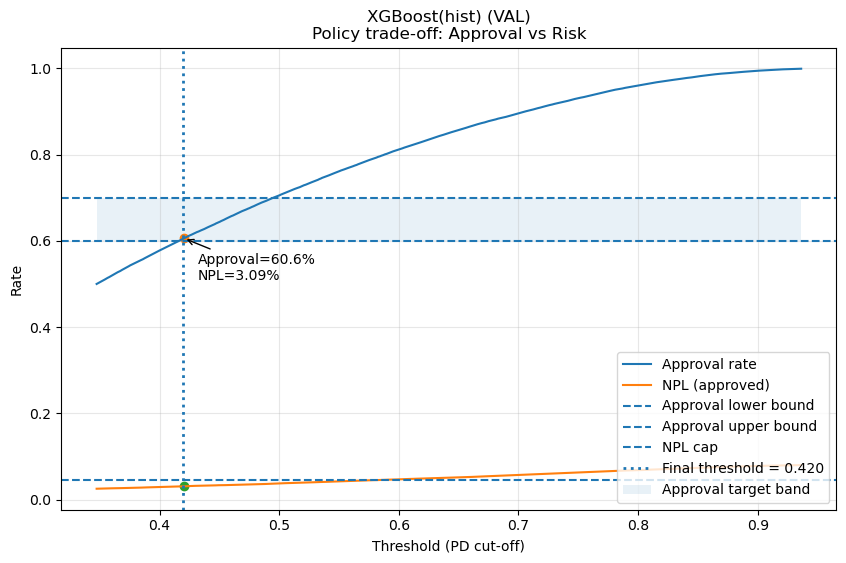

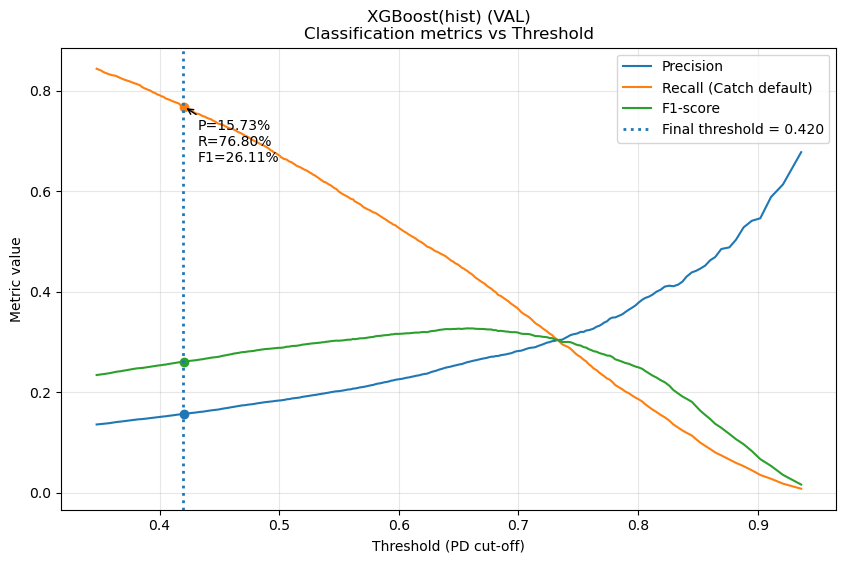

In [ ]:
# FINAL select (by VAL) + FINAL policy table (VAL + TEST) + Precision/Recall/F1 + plots
# ==== Load results dataframe  ====
# Cell 8 thường có `res` (DataFrame) và `results` (list). Ưu tiên `res` nếu có.
if "res" in globals() and isinstance(res, pd.DataFrame):
    res2 = res.copy()
elif "results" in globals():
    res2 = pd.DataFrame(results).copy()
else:
    raise AssertionError("Không tìm thấy `res` hoặc `results`. Hãy chạy lại Cell 8.")

# ==== Feasibility flag on VAL ====
res2["is_feasible_val"] = (
    (res2["val_approval"] >= APPROVAL_TARGET_LOW) &
    (res2["val_approval"] <= APPROVAL_TARGET_HIGH) &
    (res2["val_npl_approved"] <= NPL_CAP_APPROVED)
)

# ==== Rank BY VAL ONLY ====
# ưu tiên: feasible -> catch_default cao -> NPL approved thấp -> approval cao -> (nếu có) val_auc cao
sort_cols = ["is_feasible_val", "val_catch_default", "val_npl_approved", "val_approval"]
asc = [False, False, True, False]

if "val_auc" in res2.columns:
    sort_cols.append("val_auc")
    asc.append(False)

res2_sorted = res2.sort_values(by=sort_cols, ascending=asc).reset_index(drop=True)

print("=== FEASIBILITY CHECK & RANKING (VAL ONLY) ===")
show_cols = ["model", "is_feasible_val", "threshold", "val_approval", "val_npl_approved", "val_catch_default"]
if "val_auc" in res2_sorted.columns: show_cols.append("val_auc")
if "val_ap" in res2_sorted.columns: show_cols.append("val_ap")

print(res2_sorted[show_cols].to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# ==== Select FINAL model by VAL ranking ====
final_model_name = res2_sorted.loc[0, "model"]
final_threshold = float(res2_sorted.loc[0, "threshold"])
final_pipeline = artifacts[final_model_name]["pipeline"]

print("\n=== SELECTED FINAL MODEL (by VAL) ===")
print("final_model_name:", final_model_name)
print("final_threshold :", final_threshold)

# ==== helpers ====
def summarize_policy_and_metrics(y_true, proba, t):
    y_true = np.asarray(y_true).astype(int)
    proba = np.asarray(proba)

    approved = proba < t
    rejected = ~approved

    approval_rate = approved.mean()
    npl_approved  = y_true[approved].mean() if approved.sum() > 0 else np.nan

    # positive = default = 1 (reject)
    y_pred = (proba >= t).astype(int)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    acc  = accuracy_score(y_true, y_pred)
    catch_default = rec

    return approval_rate, npl_approved, catch_default, prec, rec, f1, acc

def build_policy_table_with_metrics(y_true, proba, thresholds):
    rows = []
    for t in thresholds:
        appr, npl_app, catch, prec, rec, f1, acc = summarize_policy_and_metrics(y_true, proba, t)
        rows.append([t, appr, npl_app, catch, prec, rec, f1, acc])
    return pd.DataFrame(rows, columns=[
        "threshold","approval_rate","npl_approved","catch_default",
        "precision","recall","f1","accuracy"
    ])

# ==== compute probs ====
proba_val  = final_pipeline.predict_proba(X_val)[:, 1]
proba_test = final_pipeline.predict_proba(X_test)[:, 1]

# AUC/AP: tính 1 lần (không phụ thuộc threshold)
val_auc  = roc_auc_score(y_val, proba_val)
val_ap   = average_precision_score(y_val, proba_val)
test_auc = roc_auc_score(y_test, proba_test)
test_ap  = average_precision_score(y_test, proba_test)

# threshold grid by quantiles (stable)
qs = np.linspace(0.50, 0.999, 350)
thr_grid = np.unique(np.quantile(proba_val, qs))
thr_grid = np.clip(thr_grid, 1e-8, 1-1e-8)

policy_val  = build_policy_table_with_metrics(y_val,  proba_val,  thr_grid)
policy_test = build_policy_table_with_metrics(y_test, proba_test, thr_grid)

# ===== Filter in approval band (VAL) =====
band_val = policy_val[
    (policy_val["approval_rate"] >= APPROVAL_TARGET_LOW) &
    (policy_val["approval_rate"] <= APPROVAL_TARGET_HIGH)
].copy()

feasible_band_val = band_val[band_val["npl_approved"] <= NPL_CAP_APPROVED].copy()

print("\n=== POLICY SUMMARY (VAL) within approval band ===")
print("Rows in band:", len(band_val), "| Feasible (NPL<=cap):", len(feasible_band_val))

if len(feasible_band_val) > 0:
    top_feasible = feasible_band_val.sort_values(
        ["catch_default","approval_rate","npl_approved"],
        ascending=[False, False, True]
    ).head(12)

    print("\nTop feasible policies on VAL (approval band & NPL cap) + metrics:")
    print(top_feasible.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
else:
    print("\nNo feasible rows found in band on VAL. (Nếu xảy ra, kiểm tra lại business targets hoặc model quá yếu.)")

# ===== Performance at final_threshold (locked) =====
val_star  = summarize_policy_and_metrics(y_val,  proba_val,  final_threshold)
test_star = summarize_policy_and_metrics(y_test, proba_test, final_threshold)

print("\n=== FINAL THRESHOLD PERFORMANCE (policy + metrics) ===")
print("Chosen threshold:", final_threshold)

print("VAL : approval={:.2%}, NPL_app={:.2%}, catch={:.2%} | prec={:.2%}, rec={:.2%}, f1={:.2%}, acc={:.2%} | AUC={:.4f}, AP={:.4f}".format(
    val_star[0], val_star[1], val_star[2], val_star[3], val_star[4], val_star[5], val_star[6], val_auc, val_ap
))
print("TEST: approval={:.2%}, NPL_app={:.2%}, catch={:.2%} | prec={:.2%}, rec={:.2%}, f1={:.2%}, acc={:.2%} | AUC={:.4f}, AP={:.4f}".format(
    test_star[0], test_star[1], test_star[2], test_star[3], test_star[4], test_star[5], test_star[6], test_auc, test_ap
))


# ===== Plots (VAL) =====
# 1) Approval & NPL approved vs threshold
plt.figure(figsize=(10, 6))

# Curves
plt.plot(policy_val["threshold"], policy_val["approval_rate"], label="Approval rate")
plt.plot(policy_val["threshold"], policy_val["npl_approved"], label="NPL (approved)")

# Business constraints
plt.axhline(APPROVAL_TARGET_LOW, linestyle="--", label="Approval lower bound")
plt.axhline(APPROVAL_TARGET_HIGH, linestyle="--", label="Approval upper bound")
plt.axhline(NPL_CAP_APPROVED, linestyle="--", label="NPL cap")

# Final threshold marker
plt.axvline(final_threshold, linestyle=":", linewidth=2, label=f"Final threshold = {final_threshold:.3f}")

# Highlight approval band
plt.fill_between(
    policy_val["threshold"],
    APPROVAL_TARGET_LOW,
    APPROVAL_TARGET_HIGH,
    alpha=0.1,
    label="Approval target band"
)

# Annotation at final point
final_row = policy_val.loc[
    (policy_val["threshold"] - final_threshold).abs().idxmin()
]

plt.scatter(final_row["threshold"], final_row["approval_rate"])
plt.scatter(final_row["threshold"], final_row["npl_approved"])

plt.annotate(
    f"Approval={final_row['approval_rate']:.1%}\nNPL={final_row['npl_approved']:.2%}",
    (final_row["threshold"], final_row["approval_rate"]),
    xytext=(10, -30),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->")
)

plt.title(f"{final_model_name} (VAL)\nPolicy trade-off: Approval vs Risk")
plt.xlabel("Threshold (PD cut-off)")
plt.ylabel("Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# 2) Precision / Recall / F1 vs threshold
plt.figure(figsize=(10, 6))

plt.plot(policy_val["threshold"], policy_val["precision"], label="Precision")
plt.plot(policy_val["threshold"], policy_val["recall"], label="Recall (Catch default)")
plt.plot(policy_val["threshold"], policy_val["f1"], label="F1-score")

# Final threshold marker
plt.axvline(final_threshold, linestyle=":", linewidth=2, label=f"Final threshold = {final_threshold:.3f}")

# Annotate metrics at final threshold
plt.scatter(final_row["threshold"], final_row["precision"])
plt.scatter(final_row["threshold"], final_row["recall"])
plt.scatter(final_row["threshold"], final_row["f1"])

plt.annotate(
    f"P={final_row['precision']:.2%}\nR={final_row['recall']:.2%}\nF1={final_row['f1']:.2%}",
    (final_row["threshold"], final_row["recall"]),
    xytext=(10, -40),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->")
)

plt.title(f"{final_model_name} (VAL)\nClassification metrics vs Threshold")
plt.xlabel("Threshold (PD cut-off)")
plt.ylabel("Metric value")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Keep for next steps
final_policy_val = policy_val
final_policy_test = policy_test
final_model_pipeline = final_pipeline
final_model_threshold = final_threshold
final_model_name_out = final_model_name

### Kết luận

Chốt **XGBoost(hist)** với ngưỡng **0.4198796358704566**. Ở validation, mô hình duyệt khoảng **60.50%** và tỷ lệ vỡ nợ trong nhóm được duyệt khoảng **3.09%**, thấp hơn cap khá an toàn. Mô hình cũng bắt được khoảng **76.86%** các ca default.

Với test tỷ lệ duyệt khoảng **60.95%**, tỷ lệ vỡ nợ nhóm được duyệt khoảng **3.04%**, và catch default khoảng **77.08%**. Các chỉ số như precision và F1 không cao (precision khoảng 15.93%), nhưng điều này cũng khá bình thường trong bài toán lệch lớp và để bắt được nhiều ca rủi ro thường phải chấp nhận báo động sai nhiều hơn. 

## 11) Refit FINAL model (Train+Val) & tạo submission

Khi đã chốt được mô hình và ngưỡng, bước tiếp theo là train lại mô hình trên nhiều dữ liệu hơn để tận dụng tối đa thông tin. Tôi sẽ gộp train và validation lại rồi fit một lần cuối. Sau đó, chúng ta chấm điểm cho `application_test`.

Điểm quan trọng ở đây là tính nhất quán: preprocess pipeline phải giống hệt lúc đánh giá, và ngưỡng quyết định phải giữ nguyên như đã chốt. Dưới đây tôi sẽ tạo file submission với cột `TARGET` ở dạng nhị phân 0/1. 



In [ ]:
# Refit FINAL model on Train+Val & score application_test

t_star = float(final_threshold)
print(f"FINAL MODEL: {final_model_name} | FIXED THRESHOLD: {t_star:.6f}")

# ===== 1) Refit model on Train + Val =====
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

final_pipeline_tv = clone(final_pipeline)
final_pipeline_tv.fit(X_trainval, y_trainval)

# ===== 2) Score application_test =====
X_kaggle = (
    test_2
    .drop(columns=[ID_COL])
    .reindex(columns=train_2.drop(columns=[ID_COL, TARGET_COL]).columns)
)

proba_kaggle = final_pipeline_tv.predict_proba(X_kaggle)[:, 1]
pred01 = (proba_kaggle >= t_star).astype(int)   # 1 = high risk (reject)

# ===== 3) Export submission =====
submission = pd.DataFrame({
    ID_COL: test_2[ID_COL],
    TARGET_COL: pred01
})

print("\nPrediction summary:")
print(submission[TARGET_COL].value_counts(normalize=True).rename("rate"))

submission.to_csv("submission_target_01.csv", index=False)
print("\nSaved: submission_target_01.csv")
